In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install pandas numpy matplotlib scikit-learn
!pip3 install pytorch-ignite

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import RootMeanSquaredError
from ignite.handlers import EarlyStopping

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [5]:
def remove_outliers(df, quantile=0.05):
    Q1 = df.quantile(quantile)
    Q3 = df.quantile(1-quantile)
    IQR = Q3 - Q1
    
    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

def apply_feature_engineering(df: pd.DataFrame, keep_outliers) -> pd.DataFrame:
    df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].mean())
    custom_encoding = {"ISLAND": 4, "NEAR OCEAN": 3, "NEAR BAY": 2, "<1H OCEAN": 1, "INLAND": 0}
    df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
    df = df.drop("ocean_proximity", axis=1)
    df["rooms_per_bedroom"] = df["total_rooms"] / df["total_bedrooms"]
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["encoded_position"] = df["longitude"] + df["latitude"]
    df["population_per_bedrooms"] = df["population"] / df["total_bedrooms"]
    df["target"] = df["median_house_value"]
    df = df.drop("median_house_value", axis=1)
    if not keep_outliers:
        df = remove_outliers(df, 0.05)
    return df

In [6]:
df_train = apply_feature_engineering(df_train, True)
df_test = apply_feature_engineering(df_test, False)

X_train = df_train.drop("target", axis=1)
y_train = df_train["target"]

X_test = df_test.drop("target", axis=1)
y_test = df_test["target"]

/tmp/ipykernel_17149/285434561.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
/tmp/ipykernel_17149/285434561.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]


In [7]:
class MLPRegressor(nn.Module):
    def __init__(self, inputs: int, layers: list[int], dropout_rate: int = 0, activation_func="relu"):
        super(MLPRegressor, self).__init__()
        self.layers = nn.ModuleList()
        self.layers_per_dropout = 0 if dropout_rate == 0 else len(layers) // dropout_rate
        count = 0
        for n_nodes in layers:
            self.layers.append(nn.Linear(inputs, n_nodes))
            self.layers.append(nn.ReLU()) if activation_func == "relu" else nn.Sigmoid()
            count += 1
            if self.layers_per_dropout == count:
                self.layers.append(nn.Dropout(dropout_rate))
                count = 0
            inputs = n_nodes
        self.output_layer = nn.Linear(layers[-1], 1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

In [8]:
def build_model(inputs: int,
                layers: list[int],
                device: str,
                dropout_rate: float = 0.0,
                activation_func: str = "relu",
                optimizer: str = "adam"):
    model = MLPRegressor(inputs, layers, dropout_rate, activation_func).to(device)
    criterion = nn.MSELoss()
    if optimizer == "adam":
        optimizer = optim.Adam(model.parameters())
    elif optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    return model, criterion, optimizer

def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=100, patience=None):
    trainer = create_supervised_trainer(model, optimizer, criterion)
    evaluator = create_supervised_evaluator(model, metrics={'rmse': RootMeanSquaredError()})

    train_losses = []
    valid_losses = []

    if patience is not None:
        handler = EarlyStopping(patience=patience, score_function=lambda engine: -engine.state.metrics['rmse'], trainer=trainer)
        evaluator.add_event_handler(Events.COMPLETED, handler)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_loss(trainer):
        print(f"Epoch {trainer.state.epoch}/{epochs}, Train Loss: {trainer.state.output:.4f}")
        train_losses.append(trainer.state.output)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_metrics(trainer):
        evaluator.run(valid_loader)
        metrics = evaluator.state.metrics
        print(f"Epoch {trainer.state.epoch}/{epochs}, Validation RMSE: {metrics['rmse']:.4f}")
        valid_losses.append(metrics['rmse'])

    trainer.run(train_loader, max_epochs=epochs)

    return train_losses, valid_losses

In [9]:
pipe = Pipeline([
    ("scaler", StandardScaler())
])

pipe.fit(X_train)

X_train_scaled = torch.tensor(pipe.transform(X_train), dtype=torch.float32).to(device)
X_test_scaled = torch.tensor(pipe.transform(X_test), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1).to(device)

model, criterion, optimizer = build_model(X_train_scaled.shape[1], [64, 64, 64, 64, 64, 64], device, 0.1, "relu", "adam")
train_loader = DataLoader(TensorDataset(X_train_scaled, y_train_tensor), batch_size=16, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_test_scaled, y_test_tensor), batch_size=16, shuffle=False)


In [10]:
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

def plot_rmse(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(epochs, np.sqrt(train_losses), label="Training")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")
    plt.show()

In [11]:
train_losses, valid_losses = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=1000, patience=20)

Epoch 1/1000, Train Loss: 7528560640.0000
Epoch 1/1000, Validation RMSE: 69663.2869
Epoch 2/1000, Train Loss: 4460993024.0000
Epoch 2/1000, Validation RMSE: 67769.5650
Epoch 3/1000, Train Loss: 3315958528.0000
Epoch 3/1000, Validation RMSE: 65067.5035
Epoch 4/1000, Train Loss: 4037274112.0000
Epoch 4/1000, Validation RMSE: 64430.4570
Epoch 5/1000, Train Loss: 2884223744.0000
Epoch 5/1000, Validation RMSE: 63856.9646
Epoch 6/1000, Train Loss: 2957346048.0000
Epoch 6/1000, Validation RMSE: 63425.7003
Epoch 7/1000, Train Loss: 2439182080.0000
Epoch 7/1000, Validation RMSE: 63136.3250
Epoch 8/1000, Train Loss: 3143104512.0000
Epoch 8/1000, Validation RMSE: 61786.3145
Epoch 9/1000, Train Loss: 1275470208.0000
Epoch 9/1000, Validation RMSE: 61409.6364
Epoch 10/1000, Train Loss: 4583841280.0000
Epoch 10/1000, Validation RMSE: 60527.9382
Epoch 11/1000, Train Loss: 2198212096.0000
Epoch 11/1000, Validation RMSE: 59523.7732
Epoch 12/1000, Train Loss: 8833016832.0000
Epoch 12/1000, Validation RMS

2024-04-28 19:36:26,176 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 149/1000, Validation RMSE: 52108.3729


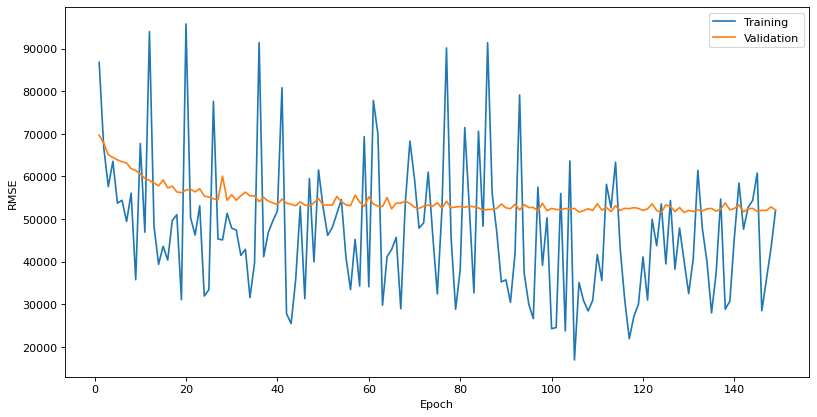

In [12]:
plot_rmse(train_losses, valid_losses)

In [13]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_scaled)
    rmse_value = rmse(y_test_tensor, y_pred_tensor)
    print("Root Mean Squared Error:", rmse_value.item())

Root Mean Squared Error: 52108.37890625
